In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

from myutils.metrics import mapk

In [3]:
train_log_df = pd.read_csv('../datasets/atmaCup16_Dataset/train_log.csv')
train_df = pd.read_csv('../datasets/atmaCup16_Dataset/train_label.csv')
test_log_df = pd.read_csv('../datasets/atmaCup16_Dataset/test_log.csv')
yado_df = pd.read_csv('../datasets/atmaCup16_Dataset/yado.csv')

train_session_only_df = train_df[['session_id']]
test_session_only_df = pd.read_csv('../datasets/atmaCup16_Dataset/test_session.csv')

In [4]:
train_test_log_df = pd.concat([train_log_df, test_log_df], axis=0).reset_index(drop=True)

In [5]:
yado_df['lrg_cd'].value_counts()

lrg_cd
7763c74e2efa67a522125d9d3d7dde25    227
c9d5e891463e5389c42d16f987ed30bd    202
e5cfcc0a43c82072aca11628ff0add53    195
e2034d4f2fbe0874f8ac58f6f111f182    192
9ab5718fd88c6e5f9fec37a51827d428    179
                                   ... 
6d99b27a34445e288d72865bb705143d      6
d30b0e6b0acec0fe0d185ae8c0e876dd      6
b3272116f48a31145befc8bcfd87b028      6
0f264346fe37eb6227714aa472bd039a      5
1fc2b77a4e271d198b1a4bfdbda85490      5
Name: count, Length: 299, dtype: int64

In [6]:
"""
train_log_session_yad_df = train_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values[-1])
train_log_session_yad_df = train_log_session_yad_df.reset_index()

last_item_df = pd.merge(train_df[['session_id']], train_log_session_yad_df, on='session_id', how='left')
last_item_df = pd.merge(last_item_df, yado_df[['yad_no', 'lrg_cd']], on='yad_no',how='left')
"""

"\ntrain_log_session_yad_df = train_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values[-1])\ntrain_log_session_yad_df = train_log_session_yad_df.reset_index()\n\nlast_item_df = pd.merge(train_df[['session_id']], train_log_session_yad_df, on='session_id', how='left')\nlast_item_df = pd.merge(last_item_df, yado_df[['yad_no', 'lrg_cd']], on='yad_no',how='left')\n"

In [7]:
lrg_cd_to_yad_dict = yado_df.groupby('lrg_cd')['yad_no'].apply(lambda x: x.tolist()).to_dict()

In [8]:
from collections import defaultdict, Counter
counter = Counter(train_test_log_df['yad_no'].values)

# counterの値で、yad_noをソート
for lrg_cd in lrg_cd_to_yad_dict.keys():
    lrg_cd_to_yad_dict[lrg_cd] = sorted(lrg_cd_to_yad_dict[lrg_cd], key=lambda x: counter[x], reverse=True)

## recall計算用

recall: 0.9384928194861066

In [9]:
def calc_recall(train_df, yado_df):
    # train_df = pd.merge(train_df, yado_df[['yad_no', 'lrg_cd']], on='yad_no', how='left')
    
    session_df = train_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values[-1]).reset_index()
    session_df = pd.merge(train_session_only_df, session_df, on='session_id', how='left')

    session_df = pd.merge(session_df, yado_df[['yad_no', 'lrg_cd']], on='yad_no', how='left')

    cnt = 0
    for last_item, lrg_cd, true_item in zip(session_df['yad_no'].values, session_df['lrg_cd'].values, train_df['yad_no'].values):
        if true_item in lrg_cd_to_yad_dict[lrg_cd]:
            cnt += 1
    print(cnt / len(train_df))
# calc_recall(train_df, yado_df)



In [10]:
results = []

for lrg_cd in lrg_cd_to_yad_dict.keys():
    yad_no_list = lrg_cd_to_yad_dict[lrg_cd]

    # for yad_no in yad_no_list[:20]:
    for yad_no in yad_no_list:
        results.append([lrg_cd, yad_no, counter[yad_no]])

lrg_cd_count_df = pd.DataFrame(results, columns=['lrg_cd', 'yad_no', 'count'])

In [11]:
lrg_cd_count_df

,lrg_cd,yad_no,count
0,0154defaec6c10404d20ecd556b6bd10,6605,350
1,0154defaec6c10404d20ecd556b6bd10,2843,338
2,0154defaec6c10404d20ecd556b6bd10,7215,237
3,0154defaec6c10404d20ecd556b6bd10,5567,178
4,0154defaec6c10404d20ecd556b6bd10,3485,155
...,...,...,...
13801,ff6cf77545873220271ee1894fbe85ed,10479,2
13802,ff6cf77545873220271ee1894fbe85ed,13759,2
13803,ff6cf77545873220271ee1894fbe85ed,4459,1
13804,ff6cf77545873220271ee1894fbe85ed,11106,1


In [12]:
# できれば、最後以外にも、2つ前とか3つ前とかも考慮したい
def make_candidate_same_area(target_log_df: pd.DataFrame, session_only_df: pd.DataFrame):

    session_df = target_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values[-1]).reset_index()
    session_df = pd.merge(session_only_df, session_df, on='session_id', how='left')

    session_df = pd.merge(session_df, yado_df[['yad_no', 'lrg_cd']], on='yad_no', how='left')
    
    # del session_df['yad_no']
    session_df.rename(columns={'yad_no': 'last_item'}, inplace=True)
    
    # session_df.rename(columns={'yad_no': 'prev_item'}, inplace=True)
    session_df = pd.merge(session_df, lrg_cd_count_df, on='lrg_cd', how='left')
    del session_df['lrg_cd']
    
    # last_itemは取り除く
    session_df = session_df[session_df['yad_no'] != session_df['last_item']].reset_index(drop=True)
    del session_df['last_item']

    session_df['rank'] = session_df.groupby('session_id')['count'].rank(ascending=False, method='min')

    pred_df = session_df.groupby('session_id')['yad_no'].apply(lambda x: x.tolist()).reset_index()
    pred_df = pd.merge(session_only_df, pred_df, on='session_id', how='left')

    pred_df['yad_no'] = pred_df['yad_no'].apply(lambda d: d if isinstance(d, list) else [])

    return session_df, pred_df

In [13]:
train_session_df, train_pred_df = make_candidate_same_area(train_log_df, train_session_only_df)
test_session_df, test_pred_df = make_candidate_same_area(test_log_df, test_session_only_df)

In [14]:
mapk(train_df['yad_no'].to_list(), train_pred_df['yad_no'].to_list(), k=10)

0.12783748343823226

In [15]:
train_session_df.to_pickle('../datasets/candidate_df/same_area_lrg_cd_train.pkl')
test_session_df.to_pickle('../datasets/candidate_df/same_area_lrg_cd_test.pkl')


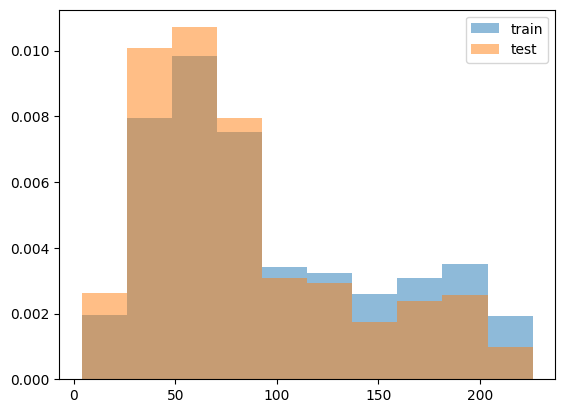

In [16]:
train_pred_df['pred_count'] = train_pred_df['yad_no'].apply(lambda d: len(d))
test_pred_df['pred_count'] = test_pred_df['yad_no'].apply(lambda d: len(d))

plt.hist(train_pred_df['pred_count'], label='train', alpha=0.5, density=True)
plt.hist(test_pred_df['pred_count'], label='test', alpha=0.5, density=True)
plt.legend()

In [17]:
train_pred_df['pred_count'].describe()

count    288698.000000
mean         96.266237
std          58.007551
min           4.000000
25%          53.000000
50%          73.000000
75%         136.000000
max         226.000000
Name: pred_count, dtype: float64

In [18]:
test_pred_df['pred_count'].describe()

count    174700.000000
mean         83.962026
std          52.788745
min           4.000000
25%          43.000000
50%          69.000000
75%         114.000000
max         226.000000
Name: pred_count, dtype: float64